# Analyze parsing task behavior

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pingouin as pg
from mindstorm import statplot
from tesser import tasks

main_dir = os.environ['TESSER_DIR']
data_dir = os.path.join(main_dir, 'Data')
fig_dir = os.path.join(main_dir, 'Figures', 'plots')

## Load data for all participants

In [2]:
parse = tasks.load_parse(data_dir)
parse.head(25)

,subject,run,block,trial,trial_type,path_type,community,object,object_type,response,response_time
0,100,1,1,1,structured,structured,1,21,central,0,NaN
1,100,1,1,2,structured,structured,1,3,boundary,0,NaN
2,100,1,1,3,structured,structured,1,20,central,1,0.818487
3,100,1,1,4,structured,structured,1,3,boundary,0,NaN
4,100,1,1,5,structured,structured,1,2,central,1,0.914617
5,100,1,1,6,structured,structured,1,3,boundary,1,0.769570
6,100,1,1,7,structured,structured,2,4,boundary,0,NaN
7,100,1,1,8,structured,structured,2,8,central,1,0.949561
8,100,1,1,9,structured,structured,2,10,boundary,0,NaN
9,100,1,1,10,structured,structured,2,8,central,0,NaN


## Calculate response probability for transitions and non-transitions

In [3]:
parse = tasks.score_parse(parse)
results = tasks.parse_perf(parse)
results

,parse_type,subject,trial_type,response
0,transition,100,hamiltonian,0.365385
1,transition,100,structured,0.473684
2,transition,101,hamiltonian,0.296296
3,transition,101,structured,0.384615
4,transition,102,hamiltonian,0.740741
...,...,...,...,...
143,other,136,structured,0.179348
144,other,137,hamiltonian,0.055556
145,other,137,structured,0.290761
146,other,138,hamiltonian,0.165644


## Compare parsing responses for random walk and Hamiltonian blocks

In [4]:
light = [
    (240 / 256, 136 / 256, 84 / 256),
    (238 / 256, 199 / 256, 181 / 256),
]
dark = [
    (236 / 256, 104 / 256, 38 / 256),
    (238 / 256, 166 / 256, 130 / 256),
]
sns.color_palette(light + dark)

[(0.9375, 0.53125, 0.328125),
 (0.9296875, 0.77734375, 0.70703125),
 (0.921875, 0.40625, 0.1484375),
 (0.9296875, 0.6484375, 0.5078125)]

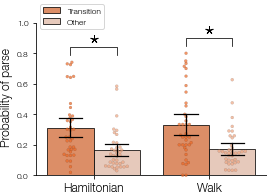

In [5]:
fig, ax = plt.subplots(figsize=(4, 3))
statplot.plot_swarm_bar(
    results.reset_index(),
    x='trial_type',
    y='response',
    hue='parse_type',
    dodge=True,
    light=light,
    dark=dark,
    bar_kws={'capsize': .2},
    ax=ax,
)

# plot significance bars
x = sorted([p.get_x() + p.get_width() / 2 for p in ax.patches])
y = results.groupby(['trial_type', 'parse_type'])['response'].max().to_list()
statplot.plot_sig([x[0], x[1]], [y[0], y[1]], 0.05, ax=ax)
statplot.plot_sig([x[2], x[3]], [y[2], y[3]], 0.05, ax=ax)

ax.set(xticklabels=['Hamiltonian', 'Walk'], ylabel='Probability of parse', ylim=[0, 1.15])
handles, labels = ax.get_legend_handles_labels()
ax.spines['left'].set_bounds(0, 1)
ax.legend(handles, ['Transition', 'Other'], fontsize='small', loc='upper left');
ax.yaxis.set_label_coords(-.1, 0.45)
fig.savefig(os.path.join(fig_dir, 'parsing_transition.pdf'))

In [6]:
pg.rm_anova(
    data=results, 
    dv='response', 
    within=['parse_type', 'trial_type'], 
    subject='subject',
)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,parse_type,0.861925,1,36,0.861925,15.131887,0.000415,0.000415,0.295938,1.0
1,trial_type,0.007860,1,36,0.007860,1.621687,0.211018,0.211018,0.043105,1.0
2,parse_type * trial_type,0.000836,1,36,0.000836,0.258816,0.614038,0.614038,0.007138,1.0


In [7]:
pivot = pd.pivot(
    results, 
    index='subject', 
    values='response', 
    columns=['trial_type', 'parse_type'],
)

In [8]:
pg.ttest(pivot[('hamiltonian', 'transition')], pivot[('hamiltonian', 'other')], paired=True)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,4.042153,36,two-sided,0.000267,"[0.07, 0.22]",0.872559,102.045,0.999317


In [9]:
pg.ttest(pivot[('structured', 'transition')], pivot[('structured', 'other')], paired=True)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,3.596103,36,two-sided,0.000961,"[0.07, 0.25]",0.874849,32.356,0.999348


In [10]:
%load_ext watermark
%watermark -v -iv

Python implementation: CPython
Python version       : 3.7.6
IPython version      : 7.11.1

pandas    : 1.2.5
numpy     : 1.18.1
mindstorm : 0.8.1
matplotlib: 3.4.2
tesser    : 0.1.0
seaborn   : 0.11.1
pingouin  : 0.3.12

